In [1]:
# Uncomment to use autoreload
%load_ext autoreload
%autoreload 2

import os
import os.path as osp
import sys
import torch
import numpy as np
from time import time
from omegaconf import OmegaConf
start = time()
import warnings
warnings.filterwarnings('ignore')

# torch.cuda.set_device(I_GPU)
DIR = os.path.dirname(os.getcwd())
ROOT = os.path.join(DIR, "..")
sys.path.insert(0, ROOT)
sys.path.insert(0, DIR)

from torch_points3d.utils.config import hydra_read
from torch_geometric.data import Data
from torch_points3d.core.multimodal.data import MMData, MMBatch
from torch_points3d.visualization.multimodal_data import visualize_mm_data
from torch_points3d.core.multimodal.image import SameSettingImageData, ImageData
from torch_points3d.datasets.segmentation.multimodal.scannet import ScannetDatasetMM
from torch_points3d.datasets.segmentation.scannet import CLASS_COLORS, CLASS_NAMES, CLASS_LABELS
from torch_points3d.metrics.segmentation_tracker import SegmentationTracker
from torch_points3d.datasets.segmentation import IGNORE_LABEL
from torch_points3d.metrics.scannet_segmentation_tracker import ScannetSegmentationTracker
from torch_points3d.metrics.colored_tqdm import Coloredtqdm as Ctq

from collections import defaultdict

from PIL import Image

import matplotlib.pyplot as plt 

%matplotlib inline

CLASS_COLORS[0] = (174.0, 199.0, 232.0)
CLASS_COLORS[-1] = (0, 0, 0)
import plotly.io as pio

#pio.renderers.default = 'jupyterlab'        # for local notebook
pio.renderers.default = 'iframe_connected'  # for remote notebook. Other working (but seemingly slower) options are: 'sphinx_gallery' and 'iframe'

import os
import os.path as osp
import copy
import torch
import hydra
import logging
import scipy.ndimage
import numpy as np
from PIL import Image
import open3d as o3d

# Import building function for model and dataset
from torch_points3d.datasets.dataset_factory import instantiate_dataset
from torch_points3d.models.model_factory import instantiate_model

# Import BaseModel / BaseDataset for type checking
from torch_points3d.models.base_model import BaseModel
from torch_points3d.datasets.base_dataset import BaseDataset

# Import from metrics
from torch_points3d.metrics.base_tracker import BaseTracker
from torch_points3d.metrics.colored_tqdm import Coloredtqdm as Ctq
from torch_points3d.metrics.model_checkpoint import ModelCheckpoint

# Utils import
from torch_points3d.utils.colors import COLORS
from torch_points3d.utils.wandb_utils import Wandb
from torch_points3d.utils.config import getattr_recursive
from torch_points3d.visualization import Visualizer
from torch_points3d.core.data_transform.transforms import PointcloudMerge
from torch_points3d.datasets.segmentation.scannet import CLASS_COLORS, CLASS_NAMES, CLASS_LABELS


log = logging.getLogger(__name__)

def get_seen_points(mm_data):
    ### Select seen points
    csr_idx = mm_data.modalities['image'][0].view_csr_indexing
    dense_idx_list = torch.arange(mm_data.modalities['image'][0].num_points).repeat_interleave(csr_idx[1:] - csr_idx[:-1])
    # take subset of only seen points without re-indexing the same point
    mm_data = mm_data[dense_idx_list.unique()]
    return mm_data

def get_mode_pred(data):
    pixel_validity = data.data.mvfusion_input[:, :, 0].bool()
    mv_preds = data.data.mvfusion_input[:, :, -1].long()
            
    valid_m2f_feats = []
    for i in range(len(mv_preds)):
        valid_m2f_feats.append(mv_preds[i][pixel_validity[i]])

    mode_preds = []
    for m2feats_of_seen_point in valid_m2f_feats:
        mode_preds.append(torch.mode(m2feats_of_seen_point.squeeze(), dim=0)[0])
    mode_preds = torch.stack(mode_preds, dim=0)
        
    return mode_preds

def get_random_view_pred(data):
    pixel_validity = data.data.mvfusion_input[:, :, 0].bool()
    mv_preds = data.data.mvfusion_input[:, :, -1].long()
            
    valid_m2f_feats = []
    for i in range(len(mv_preds)):
        valid_m2f_feats.append(mv_preds[i][pixel_validity[i]])

    selected_view_preds = []
    for m2feats_of_seen_point in valid_m2f_feats:
        selected_idx = torch.randint(low=0, high=m2feats_of_seen_point.shape[0], size=(1,))
        selected_pred = m2feats_of_seen_point[selected_idx].squeeze(0)
        selected_view_preds.append(selected_pred)
    selected_view_preds = torch.stack(selected_view_preds, dim=0)
        
    return selected_view_preds




MMData debug() function changed, please uncomment the 3rd assert line when doing inference without M2F features!
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [8]:
# Set your dataset root directory, where the data was/will be downloaded
DATA_ROOT = '/scratch-shared/fsun/dvata'

# dataset_config = 'segmentation/multimodal/Feng/scannet-val-val.yaml'   

dataset_config = 'segmentation/multimodal/Feng/scannet-superconvergence-adamw.yaml'   
# models_config = 'segmentation/multimodal/Feng/mvfusion'    # model family
# model_name = 'MVFusion_3D_small_6views'                       # specific model
# model_name = 'Res16UNet13-15'                       # specific model



# dataset_config = 'segmentation/multimodal/Feng/scannet-neucon-smallres-m2f.yaml'   
models_config = 'segmentation/multimodal/Feng/small_3d.yaml' 
models_config = 'segmentation/multimodal/Feng/view_selection_experiment.yaml' 


model_name = 'LabelFusion_Res16UNet34'

overrides = [
    'task=segmentation',
    f'data={dataset_config}',
    f'models={models_config}',
    f'model_name={model_name}',
    f'data.dataroot={DATA_ROOT}',
]

cfg = hydra_read(overrides)
OmegaConf.set_struct(cfg, False)  # This allows getattr and hasattr methods to function correctly
cfg.data.load_m2f_masks = True   # load Mask2Former predicted masks
cfg.data.m2f_preds_dirname = 'ViT_masks'
cfg.data.n_views = cfg.models[model_name].backbone.transformer.n_views
print("n_views: ", cfg.data.n_views)

# Dataset instantiation
start = time()
dataset = ScannetDatasetMM(cfg.data)
# print(dataset)|
print(f"Time = {time() - start:0.1f} sec.")

n_views:  6
Load predicted 2D semantic segmentation labels from directory  ViT_masks
initialize train dataset
initialize val dataset
Time = 32.4 sec.


In [9]:
# from torch_points3d.applications.sparseconv3d import SparseConv3d

# sparse_unet = SparseConv3d(
#     architecture='unet',
#     input_nc=3, 
#     num_layers=2,
#     backend='torchsparse')

# sparse_unet

In [10]:
# Create the model
print(f"Creating model: {cfg.model_name}")
model = instantiate_model(cfg, dataset)
print(model)

# # Load the checkpoint and recover the 'best_miou' model weights
# checkpoint = torch.load(f'{checkpoint_dir}/{model_name}.pt', map_location='cpu')
# model.load_state_dict_with_same_shape(checkpoint['models']['best_miou'], strict=False)

# Prepare the model for training
model = model.cuda()
print('Model loaded')


Creating model: LabelFusion_Res16UNet34
task:  segmentation.multimodal
tested_model_name:  LabelFusion_Res16UNet34
class_name:  LabelFusionAPIModel
model_module:  torch_points3d.models.segmentation.multimodal.Feng.label_fusion
name, cls of chosen model_cls:  LabelFusionAPIModel <class 'torch_points3d.models.segmentation.multimodal.Feng.label_fusion.LabelFusionAPIModel'>
x feature dim:  {'FEAT': 1}
nc_in:  21
nc_in:  64
nc_in:  32
nc_in:  64
nc_in:  128
Enabling checkpointing for:  
nc_in:  256
nc_in:  128
nc_in:  128
nc_in:  96
nc_in:  96
LabelFusionAPIModel(
  (backbone): LabelFusionSparseConv3dUnet(
    (inner_modules): ModuleList(
      (0): Identity()
    )
    (down_modules): ModuleList(
      (0): MultimodalBlockDown(
        (block_1): Identity()
        (block_2): Identity()
        (image): LabelFusionUnimodalBranch(
          drop_3d=None
          drop_mod=None
          keep_last_view=False
          checkpointing=
          (fusion): BimodalFusion(mode=concatenation)
     

)
Model loaded


In [22]:
test_data = dataset.train_dataset[777]
test_data = MMBatch.from_mm_data_list([test_data])

model.set_input(test_data, device='cuda:0')
model.forward(epoch=1)


TypeError: 'NoneType' object is not subscriptable

In [ ]:
model.output

# Data visualization tools

### Modeling

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BaseNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv_type = "SPARSE"
        
    def backward(self):
        self.loss_seg.backward()


    @property
    def device(self):
        return next(self.parameters()).device
    
class Linear(BaseNetwork):
    def __init__(self, feat_indices, loss_func, num_views, num_classes, use_3d=False):
        super().__init__()
        
        self.feat_indices = feat_indices
        self.loss_fn = loss_func
        self.num_views = num_views
        self.num_classes = num_classes
        self.use_3d = use_3d
            
        # in_dim = n view feats + input label one hot
        feat_dim = len(self.feat_indices) * self.num_views + self.num_classes * self.num_views
        
        if self.use_3d:
            feat_dim += 3
        
        hidden_dim = 64
        self.fc1 = nn.Sequential(
            nn.Linear(feat_dim, hidden_dim),
#             nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
#             nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, self.num_classes)
        )
        
    def set_input(self, batch, device):
        self.input = get_seen_points(batch).to(device)
        self.labels = self.input.y.to(device)
        
    def forward(self, epoch=1):
        
        # Input data processing
        input_label = self.input.data.mvfusion_input[:, :, -1].long()
        input_label_one_hot = F.one_hot(input_label, num_classes=self.num_classes).flatten(1, 2)
        
        x = self.input.data.mvfusion_input[:, :, self.feat_indices].flatten(1, 2)
        
        if self.use_3d:
            data_3d = self.input.data.x
            x = torch.cat((data_3d, x, input_label_one_hot), axis=-1)
        else:
            x = torch.cat((x, input_label_one_hot), axis=-1)

        
        # Model forward
        out = self.fc1(x)
        
        # Loss and logits
        self.output = F.log_softmax(out, dim=-1)
        self.loss_seg = self.loss_fn(self.output, self.labels)


# Bottom-up approach to view-fusion problem

- Compare XYZ vs Z-only input
- Compare small vs large 3D network
- Pre-training view-fusion and 3D backbone separately? Then finetune complete network

### LR finder

In [17]:
# # Create the model
# print(f"Creating model: {cfg.model_name}")
# model = instantiate_model(cfg, dataset)
# print(model)

# # # Load the checkpoint and recover the 'best_miou' model weights
# # checkpoint = torch.load(f'{checkpoint_dir}/{model_name}.pt', map_location='cpu')
# # model.load_state_dict_with_same_shape(checkpoint['models']['best_miou'], strict=False)

# # Prepare the model for training
# model = model.cuda()
# print('Model loaded')

BATCH_SIZE=1
dataset.create_dataloaders(
    model,
    BATCH_SIZE,  # train bs
    True,  # shuffle
    17,
    False,
    train_only=True,
    val_only=False,
    test_batch_size=1
)    

In [18]:
from lr_finder import LRFinder

criterion = nn.NLLLoss(ignore_index=IGNORE_LABEL)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=0.01, betas=(0.9, 0.99))
lr_finder = LRFinder(model, optimizer, criterion, device="cpu")
lr_finder.range_test(dataset._train_loader, end_lr=10, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

# DeepSetAttention lr_range = [0.001, 0.03]
# MVFusion_small_6views     = [0.001, 0.03]
# DeepSet_3D                = []

# SimpleLinear_3D_large     = [0.001, 0.08] 
# DeepSetAttention_Res16UNet13-12 = [0.001, 0.05]
# MVFusion_small_6views_Res16UNet13-12 = [0.001, 0.04]
# SimpleLinear_Res16UNet13-12 = [0.001, 0.1]
# SimpleLinear_Res16UNet34   =  [0.001, 0.3]

  0%|          | 0/100 [00:00<?, ?it/s]

NotImplementedError: 

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([200000, 174])
torch.Size([200000, 174])
torch.Size([200000, 174])
torch.Size([200000, 174])
torch.Size([200000, 174])
torch.Size([200000, 174])
torch.Size([200000, 174])
torch.Size([200000, 174])
torch.Size([200000, 174])
torch.Size([200000, 174])
torch.Size([192817, 174])
torch.Size([200000, 174])
torch.Size([200000, 174])
torch.Size([200000, 174])
torch.Size([200000, 174])
torch.Size([200000, 174])
torch.Size([200000, 174])
torch.Size([200000, 174])
torch.Size([200000, 174])
torch.Size([200000, 174])
torch.Size([200000, 174])
torch.Size([200000, 174])
torch.Size([200000, 174])
torch.Size([187112, 174])
torch.Size([200000, 174])
torch.Size([200000, 174])
torch.Size([200000, 174])
torch.Size([200000, 174])
torch.Size([200000, 174])
torch.Size([200000, 174])
torch.Size([200000, 174])
torch.Size([200000, 174])
torch.Size([200000, 174])
torch.Size([200000, 174])
torch.Size([200000, 174])
torch.Size([200000, 174])
torch.Size([200000, 174])
torch.Size([200000, 174])
torch.Size([

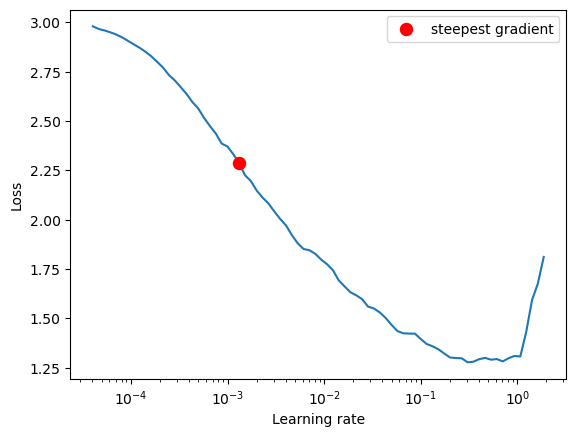

In [17]:
from lr_finder import LRFinder

criterion = nn.NLLLoss(ignore_index=IGNORE_LABEL)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=0.01, betas=(0.9, 0.99))
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(dataset._train_loader, end_lr=10, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

# DeepSetAttention lr_range = [0.001, 0.03]
# MVFusion_small_6views     = [0.001, 0.03]
# DeepSet_3D                = [0.001, 0.03]

# SimpleLinear_3D_large     = [    , 0.]   use same but add more epochs

In [92]:
BATCH_SIZE=6

dataset.create_dataloaders(
    model,
    BATCH_SIZE,  # train bs
    True,  # shuffle
    17,
    False,
    train_only=True,
    val_only=False,
    test_batch_size=1
)    

MAX_LR = 0.03
min_lr = 0.001
DIV_FACTOR = MAX_LR / min_lr

WD = 0.01

EPOCHS = 30
STEPS_PER_EPOCH = len(dataset._train_loader)
print(STEPS_PER_EPOCH)


FEAT_INDICES = [0, 1, 2, 3, 4, 5, 6, 7, 8] #9 # choose max 9

# Create models and load state_dicts    
loss_func = nn.NLLLoss(ignore_index=IGNORE_LABEL)
# model = Linear(feat_indices=FEAT_INDICES, loss_func=loss_func, num_views=cfg.data.n_views, num_classes=dataset.num_classes)
# model = model.cuda()

# print(f"Creating model: {cfg.model_name}")
# model = instantiate_model(cfg, dataset)
# # # Load the checkpoint and recover the 'best_miou' model weights
# # checkpoint = torch.load(f'{checkpoint_dir}/{model_name}.pt', map_location='cpu')
# # model.load_state_dict_with_same_shape(checkpoint['models']['best_miou'], strict=False)
# # Prepare the model for training
# model = model.cuda()
# print('Model loaded')


params = [{'params': model.head.parameters()},
          {'params': model.backbone.down_modules[0].image.parameters(), 'lr': 3}]
            
# optim = torch.optim.AdamW(params, lr=min_lr, weight_decay=WD)
optim = torch.optim.AdamW(params, lr=min_lr, weight_decay=WD, betas=(0.9, 0.99))


scheduler = torch.optim.lr_scheduler.OneCycleLR(optim, max_lr=MAX_LR, div_factor=DIV_FACTOR, 
                                                steps_per_epoch=STEPS_PER_EPOCH, epochs=EPOCHS)


200


0.001000088437198201
0.00010000884371982009


In [122]:
scheduler.step()

optim.param_groups[1]['lr'] *= 0.1


optim

AdamW (
Parameter Group 0
    amsgrad: False
    base_momentum: 0.85
    betas: (0.949959674968593, 0.99)
    capturable: False
    eps: 1e-08
    foreach: None
    initial_lr: 0.001
    lr: 0.0010116942591080064
    max_lr: 0.03
    max_momentum: 0.95
    maximize: False
    min_lr: 1e-07
    weight_decay: 0.01

Parameter Group 1
    amsgrad: False
    base_momentum: 0.85
    betas: (0.949959674968593, 0.99)
    capturable: False
    eps: 1e-08
    foreach: None
    initial_lr: 0.001
    lr: 0.00010116942591080064
    max_lr: 0.03
    max_momentum: 0.95
    maximize: False
    min_lr: 1e-07
    weight_decay: 0.01
)

In [69]:
class ModelEvaluator():
    def __init__(self, model, optim, scheduler, dataset, early_stopping=True, patience=3):
        self.model = model
        self.optim = optim
        self.scheduler = scheduler
        self.dataset = dataset
        self.early_stopping = early_stopping
        self.patience = patience
        
        self.train_tracker = ScannetSegmentationTracker(dataset, 'train', False, False, ignore_label=IGNORE_LABEL)
        self.train_tracker_baseline = ScannetSegmentationTracker(dataset, 'train', False, False, ignore_label=IGNORE_LABEL)
        self.test_tracker = ScannetSegmentationTracker(dataset, 'val', False, False, ignore_label=IGNORE_LABEL) 
        self.test_tracker_baseline = ScannetSegmentationTracker(dataset, 'val', False, False, ignore_label=IGNORE_LABEL) 

        if hasattr(self.dataset, '_train_dataloader'):
            del  self.dataset._train_dataloader
        if hasattr(self.dataset, '_val_dataloader'):
            del self.dataset._val_dataloader
        
        # Create train and validation loader
        self.dataset.create_dataloaders(
            model,
            BATCH_SIZE,  # train bs
            True,  # shuffle
            17,
            False,
            train_only=False,
            val_only=False,
            test_batch_size=1
        )    
                
    def plot_losses(self, losses, stage='train'):   
        c = 'tab:blue' if stage == 'train' else 'tab:orange'
        plt.plot(losses, label=f'{stage}_loss', color=c)
        ax = plt.gca()
        ax.set_ylim([0.0, 2.0])
        plt.legend()
        plt.grid()
        plt.show()   
        
    def plot_metrics(self, train_data, test_data):
        for k, v in train_data.items():
            plt.plot(v, label=k)
            
        for k, v in test_data.items():
            plt.plot(v, label=k)
            
        ax = plt.gca()
        ax.set_ylim([0, 100])
        plt.legend()
        plt.grid()
        plt.show()    
        
        print(train_data)
        print(test_data)
        
    def train(self, epochs):
        train_losses = []
        test_losses = []
        train_metrics = defaultdict(lambda: [])
        test_metrics = defaultdict(lambda: [])
        
        best_mIoU = 0.0
        best_mIoU_epoch = 0
        epoch_no_change = 0
        
        for epoch in range(1, epochs+1):
            train_statistics = self.train_one_epoch(epoch)
            train_out = self.train_tracker.get_metrics()
            print("training metrics: ", train_out)
            
            test_statistics = self.test_one_epoch(epoch)
            test_out = self.test_tracker.get_metrics()
            print("testing metrics: ", test_out)


                

            train_losses.extend(train_statistics)
            test_losses.extend(test_statistics)
            
            self.plot_losses(train_losses, stage='train')
            self.plot_losses(test_losses, stage='val')
            
            # Training/testing metrics
            
            for k, v in train_out.items():
                train_metrics[k].append(v)
            for k, v in test_out.items():
                test_metrics[k].append(v)

            train_metrics['loss'] = np.array(train_losses).reshape(epoch, -1).mean(axis=1) * 100
            test_metrics['loss'] = np.array(test_losses).reshape(epoch, -1).mean(axis=1) * 100
            
            if epoch > 1:
                self.plot_metrics(train_metrics, test_metrics)
                
            if self.early_stopping:
                if test_out['val_miou'] < best_mIoU:
                    epoch_no_change += 1
                else:
                    best_mIoU = test_out['val_miou']
                    best_mIoU_epoch = epoch
                    epoch_no_change = 0
                if epoch_no_change >= self.patience:
                    print("Number of epochs without validation improvement: ", epoch_no_change)
                    print(f"Best epoch: {best_mIoU_epoch} = {best_mIoU}")
                    print("Stopping training early due to prevent overfitting")
                    break
                    
            
        
    def train_one_epoch(self, epoch):
        self.model.train()
        self.train_tracker.reset('train')

        losses = []
        with Ctq(self.dataset._train_loader) as loader:
            for batch in loader:
                
                self.optim.zero_grad()
                
                self.model.set_input(batch, self.model.device)
                self.model.forward(epoch=epoch)
                
                self.model.backward()
                self.optim.step()
                self.scheduler.step()
                
                losses.append(self.model.loss_seg.item())

                # Train score
                pred = self.model.output.detach().cpu().argmax(1)
                self.train_tracker.track(gt_labels=self.model.input.y, pred_labels=pred, model=None)
                
        return losses
            
    def test_one_epoch(self, epoch):
        self.model.eval()
        self.test_tracker.reset('val')
        
        losses = []
        with Ctq(self.dataset._val_loader) as loader:
            for batch in loader:
                    
                with torch.no_grad():
                    self.model.set_input(batch, self.model.device)
                    self.model.forward(epoch=epoch)
                losses.append(self.model.loss_seg.item())
                
                pred = self.model.output.detach().cpu().argmax(1)
                self.test_tracker.track(gt_labels=self.model.input.y, pred_labels=pred, model=None)
        return losses
    
evaluator = ModelEvaluator(model, optim, scheduler, dataset, early_stopping=True, patience=5)
evaluator.train(epochs=EPOCHS)


  0%|          | 0/200 [00:01<?, ?it/s]

KeyboardInterrupt: 

### Model behavior analysis

In [6]:
test_seen_batch = dataset.val_dataset[0]
test_seen_batch = MMBatch.from_mm_data_list([test_seen_batch])

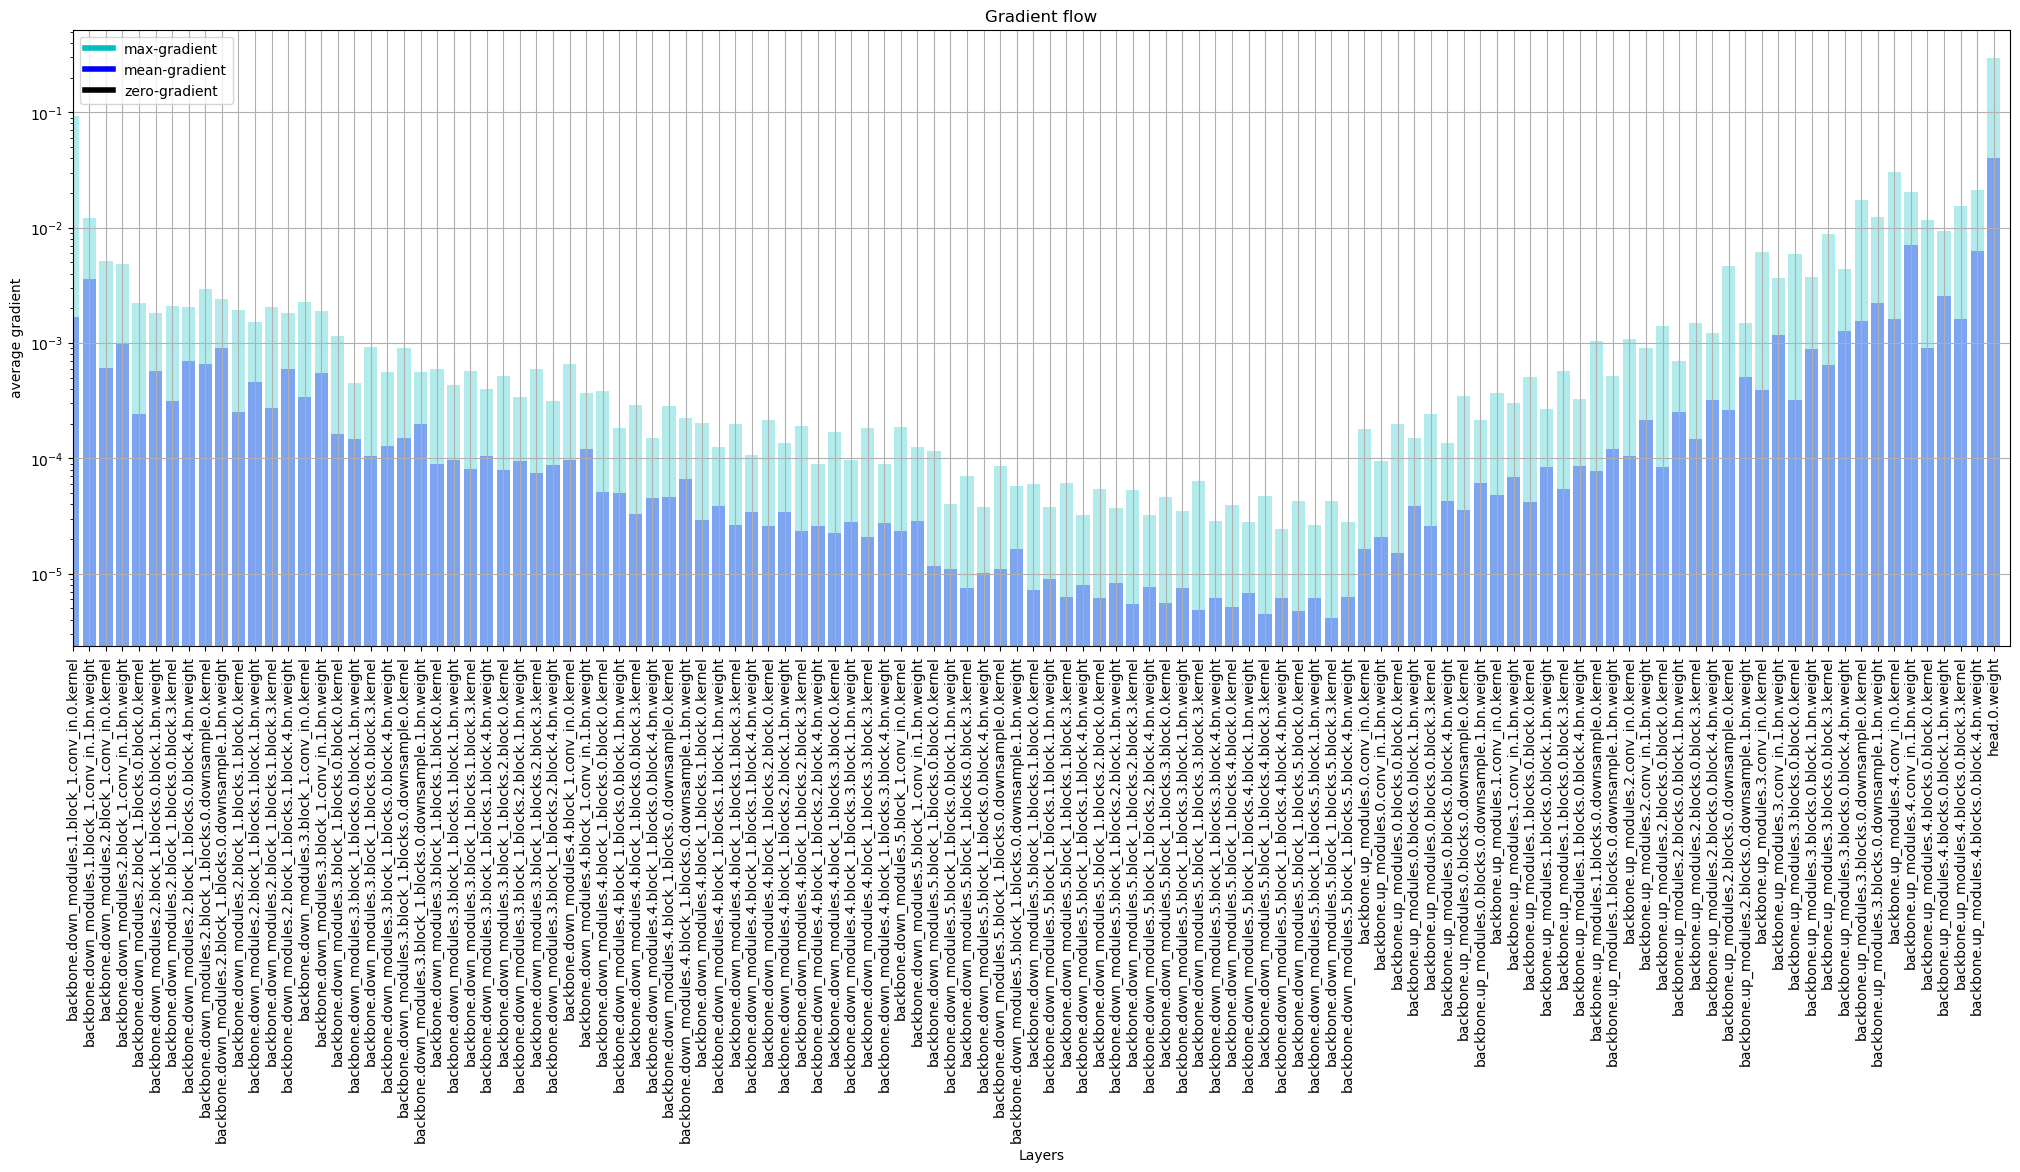

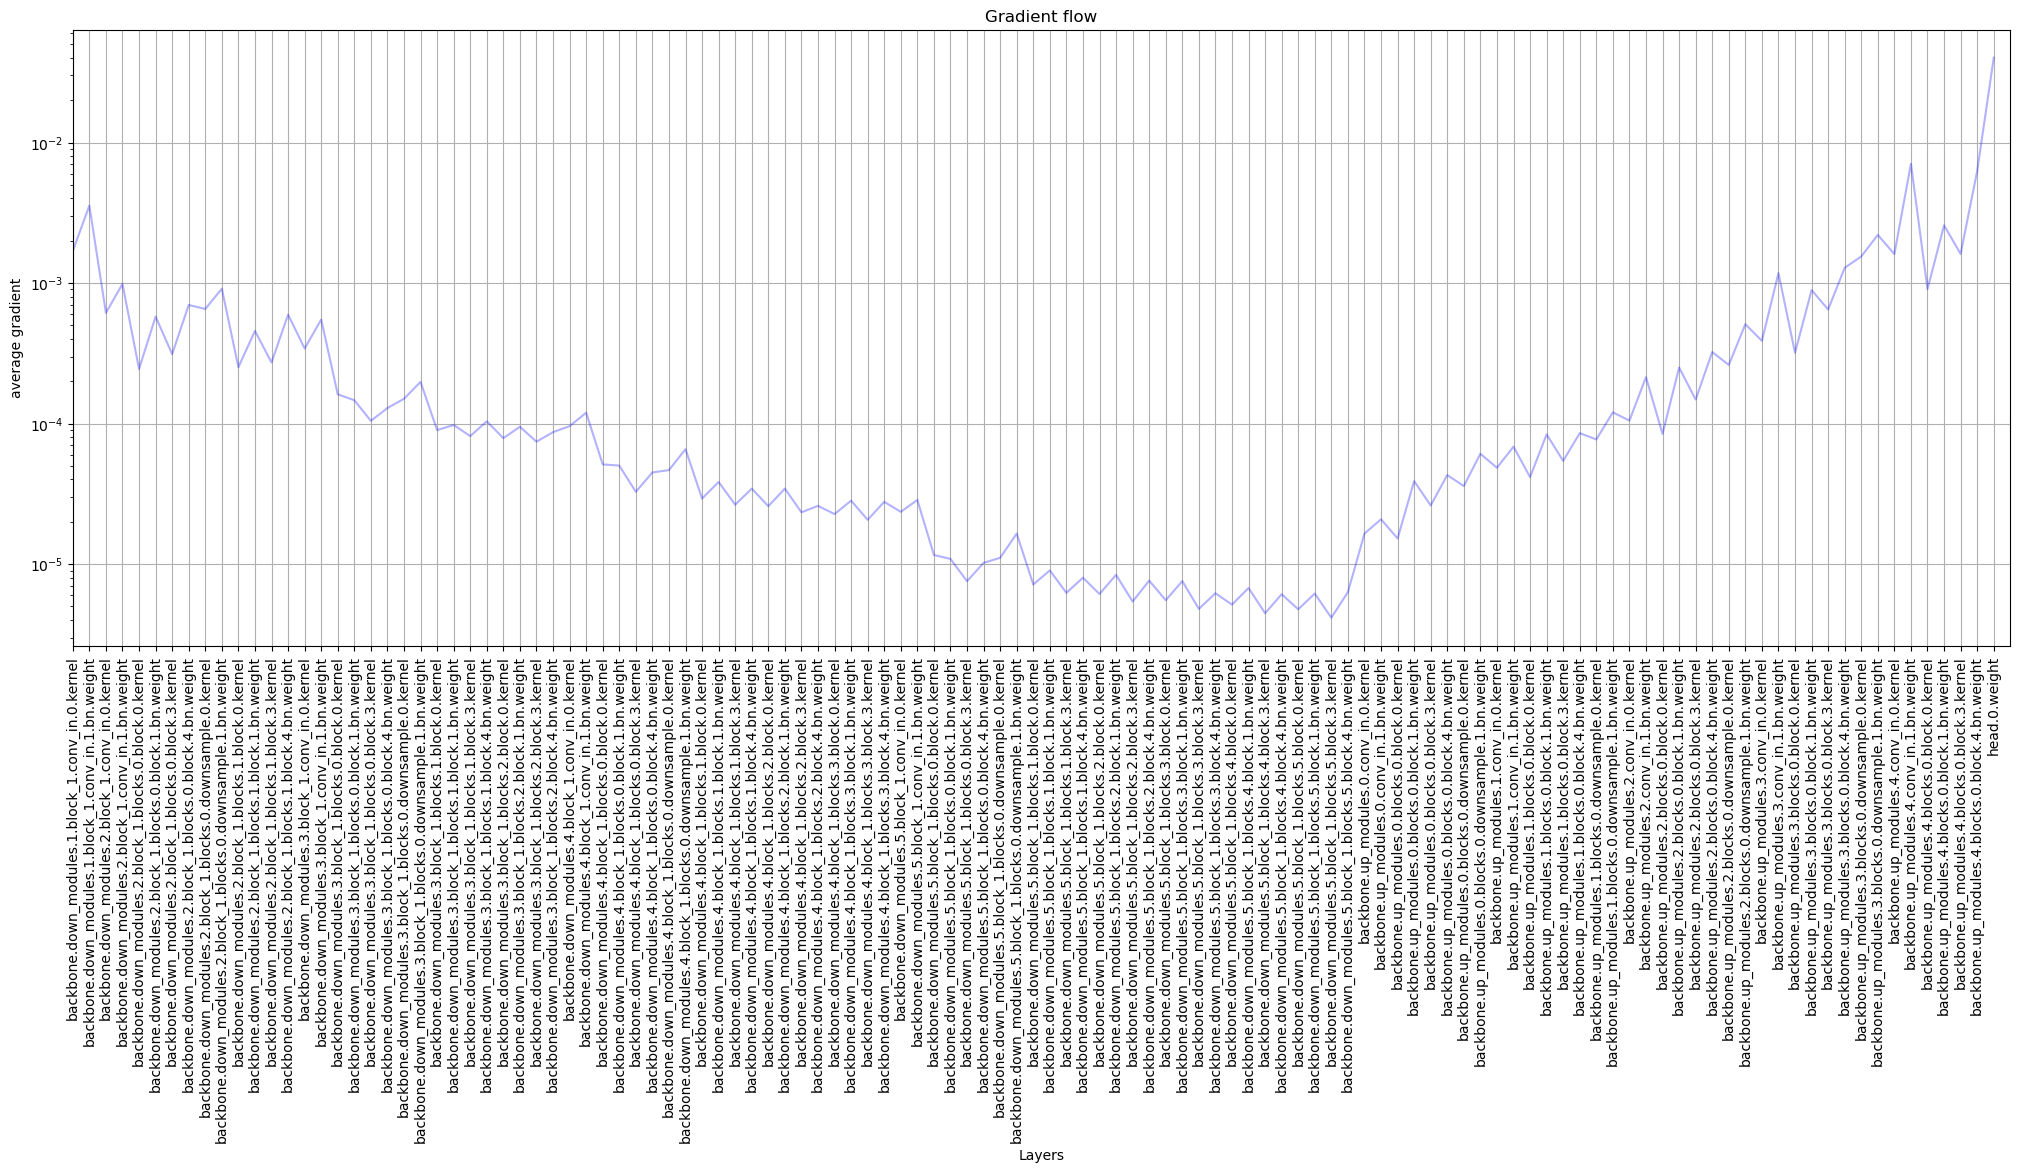

In [11]:
def plot_grad_flow_v2(named_parameters):
    from matplotlib.pyplot import Line2D
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads = []
    max_grads= []
    layers = []
    
    count = 0
    for n, p in named_parameters:
        count += 1
        if count > 33333:
            break
        if(p.requires_grad) and ("bias" not in n) and p.grad is not None:
            layers.append(n)
            ave_grads.append(p.grad.cpu().abs().mean())
            max_grads.append(p.grad.cpu().abs().max())
            
    plt.figure(figsize=(25, 8))
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.3, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.3, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=1, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
#     plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])
    plt.yscale("log")
    plt.show()
    
def plot_grad_flow(named_parameters):
    ave_grads = []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.cpu().abs().mean())
    plt.figure(figsize=(25, 8))
    plt.plot(ave_grads, alpha=0.3, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(xmin=0, xmax=len(ave_grads))
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.yscale("log")
    plt.show()
    
    
model.set_input(test_seen_batch, model.device)
model.forward(epoch=1)
model.backward()
    
plot_grad_flow_v2(model.named_parameters())

plot_grad_flow(model.named_parameters())


In [1]:
import os
import re
import concurrent.futures

from pathlib import Path

import time

s_time = time.time()

search_dirs = ["/scratch-shared/fsun"]

file_list = []

for topdir in search_dirs:
    for root, dirs, files in os.walk(topdir):
                
        for file in files:
            
            p = os.path.join(root, file)
                        
            file_list.append(p)

print("collected all files in ", time.time() - s_time)
            
def toucher(path):
    Path(path).touch()
    return path

# We can use a with statement to ensure threads are cleaned up promptly
with concurrent.futures.ThreadPoolExecutor(max_workers=32) as executor:
    # Start the load operations and mark each future with its URL
    future_to_url = {executor.submit(toucher, path): path for path in file_list}
    for future in concurrent.futures.as_completed(future_to_url):
        url = future_to_url[future]
        try:
            data = future.result()
        except Exception as exc:
            print(f'{data} generated an exception')


print("Duration: ", time.time() - s_time)

collected all files in  465.01915311813354
/scratch-shared/fsun/dvata/scannet-instance-labels-partial/raw/metadata/scannetv2_train.txt generated an exception
/scratch-shared/fsun/data/scannet/scans/scene0474_00/sens/pose/631.txt generated an exception
/scratch-shared/fsun/data/scannet/scans/scene0474_00/sens/pose/1001.txt generated an exception
/scratch-shared/fsun/data/scannet/scans/scene0474_00/sens/pose/408.txt generated an exception
/scratch-shared/fsun/data/scannet/scans/scene0638_00/m2f_masks/191.png generated an exception
Duration:  1407.4828794002533
